# Monte Carlo example

In [1]:
# Add PyTwoWay to system path, do not run this
# import sys
# sys.path.append('../../..')

In [2]:
# Import the PyTwoWay package 
# (Make sure you have installed it using pip install pytwoway)
import pytwoway as tw
import bipartitepandas as bpd

## First, optionally set parameter values for the simulated data

In [3]:
## Optional Parameters ##
sim_params = {
    'num_ind': 10000, # Number of workers
    'num_time': 5, # Time length of panel
    'firm_size': 50, # Max number of individuals per firm
    'nk': 10, # Number of firm types
    'nl': 5, # Number of worker types
    'alpha_sig': 1, # Standard error of individual fixed effect (volatility of worker effects)
    'psi_sig': 1, # Standard error of firm fixed effect (volatility of firm effects)
    'w_sig': 5, # Standard error of residual in AKM wage equation (volatility of wage shocks)
    'csort': 1, # Sorting effect
    'cnetw': 1, # Network effect
    'csig': 1, # Standard error of sorting/network effects
    'p_move': 0.5 # Probability a worker moves firms in any period
}

## Second, create a simulated Monte Carlo object using the parameter choices

In [4]:
# Create the TwoWayMonteCarlo object
twmc_net = tw.TwoWayMonteCarlo(sim_params)

## Third, optionally set parameter values for the Monte Carlo simulation

In [5]:
## Optional Parameters ##
# For FE estimation
fe_params = {
    'ncore': 1, # Number of cores to use
    'batch': 1, # Batch size to send in parallel
    'ndraw_pii': 100, # Number of draw to use in approximation for leverages
    'levfile': '', # File to load precomputed leverages
    'ndraw_tr': 5, # Number of draws to use in approximation for traces
    'he': True, # If True, compute heteroskedastic correction
    'out': 'res_fe.json', # Outputfile where FE results are saved    
    'statsonly': False, # If True, return only basic statistics
    'Q': 'cov(alpha, psi)' # Which Q matrix to consider. Options include 'cov(alpha, psi)' and 'cov(psi_t, psi_{t+1})'
}
# For CRE estimation
cre_params = {
    'ncore': 1, # Number of cores to use
    'ndraw_tr': 5, # Number of draws to use in approximation for traces
    'ndp': 50, # Number of draw to use in approximation for leverages
    'out': 'res_cre.json', # Outputfile where CRE results are saved
    'posterior': False, # If True, compute posterior variance
    'wobtw': False # If True, sets between variation to 0, pure RE
}
# For clustering (specifically for the KMeans algorithm)
KMeans_params = { # These parameters are specifically for the KMeans algorithm
                  # Read more at https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
    'n_clusters': 10,
    'init': 'k-means++',
    'n_init': 500,
    'max_iter': 300,
    'tol': 0.0001,
    'precompute_distances': 'deprecated',
    'verbose': 0,
    'random_state': None,
    'copy_x': True,
    'n_jobs': 'deprecated',
    'algorithm': 'auto'
}
# For clustering
cluster_params = {
    'measures': bpd.measures.cdfs(
        cdf_resolution=10, # How many values to use to approximate the cdfs
        measure='quantile_all' # How to compute the cdfs (
                               # 'quantile_all' to get quantiles from entire set of data,
                                    # then have firm-level values between 0 and 1;
                               # 'quantile_firm_small' to get quantiles at the firm-level
                                    # and have values be compensations if small data;
                               # 'quantile_firm_large' to get quantiles at the firm-level
                                    # and have values be compensations if large data,
                                    # note that this is up to 50 times slower than
                                    # 'quantile_firm_small' and should only be used
                                    # if the dataset is too large to copy into a dictionary
    ),
    'grouping': bpd.grouping.kmeans( # Read more at
                                  # https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
        n_clusters=10,
        init='k-means++',
        n_init=500,
        max_iter=300,
        tol=0.0001,
        precompute_distances='deprecated',
        verbose=0,
        random_state=None,
        copy_x=True,
        n_jobs='deprecated',
        algorithm='auto'
    ),
    'stayers_movers': None, # If None, clusters on entire dataset;
                         # If 'stayers', clusters on only stayers
                         # If 'movers', clusters on only movers
    't': None, # If None, clusters on entire dataset
            # If int, gives period in data to consider (only valid for non-collapsed data)
    'weighted': True, # If True, weight firm clusters by firm size
                        # (if a weight column is included, firm weight is computed using this column;
                        # otherwise, each observation has weight 1)
    'dropna': False # If True, drop observations where firms aren't clustered;
                 # If False, keep all observations
}
# For data cleaning
clean_params = {
    'connectedness': 'connected', # When computing largest connected set of firms:
        # If 'connected', keep observations in the largest connected set of firms;
        # If 'biconnected', keep observations in the largest biconnected set of firms;
        # If None, keep all observations
    'i_t_how': 'max', # How to handle worker-year duplicates
        # If 'max', keep max paying job;
        # If 'sum', sum over duplicate worker-firm-year observations,
            # then take the highest paying worker-firm sum;
        # If 'mean', average over duplicate worker-firm-year observations,
            # then take the highest paying worker-firm average.
        # Note that if multiple time and/or firm columns are included
            # (as in event study format), then data is converted to long,
            # cleaned, then reconverted to its original format
    'copy': False # If False, avoid copy
}

## Fourth, run the Monte Carlo simulation using the parameter choices

In [6]:
twmc_net.twfe_monte_carlo(
    N=500, # Number of simulations
    ncore=4, # Number of cores
    fe_params=fe_params,
    cre_params=cre_params,
    cluster_params=cluster_params,
    collapsed=True, # If True, collapse data by worker-firm spells for estimators
    clean_params=clean_params
)

## Fifth and finally, plot parameter estimates (plots show the difference from the truth)

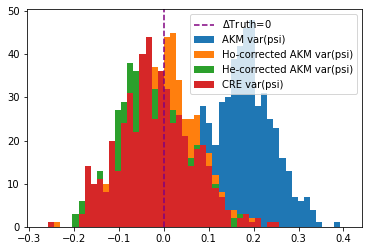

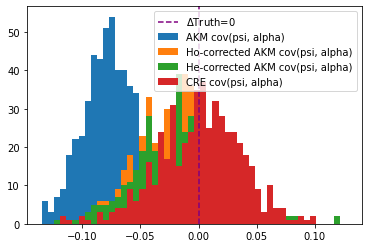

In [7]:
twmc_net.plot_monte_carlo()